


*   [TD(0) Maze Algorithm](https://chatgpt.com/c/688bf9c7-4769-464e-a2d5-7c032ac32c6f)
*   [Markov Decision Process & Reinforcement Learning](https://chatgpt.com/c/76d8ae26-0fcd-4f01-bf6e-1105d43fd315)




In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [ ]:
import numpy as np
#import gridworld_render as render_helper


class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]
        self.action_meaning = {
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)
        self.wall_state = (1, 1)
        self.start_state = (2, 0)
        self.agent_state = self.start_state

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)

In [ ]:
env = GridWorld()

In [ ]:
import numpy as np
import random

def td_zero(maze, start, end, alpha, gamma, episodes):
    V = np.zeros(maze.shape)
    for _ in range(episodes):
        state = start
        while state != end:
            next_state = get_next_state(maze, state, end)
            reward = get_reward(maze, state, end)
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            state = next_state
    return V

def get_possible_next_states(maze, state):
    x, y = state
    possible_states = []
    if x > 0: # 上に移動
        possible_states.append((x - 1, y))
    if x < maze.shape[0] - 1: # 下に移動
        possible_states.append((x + 1, y))
    if y > 0: # 左に移動
        possible_states.append((x, y - 1))
    if y < maze.shape[1] - 1: # 右に移動
        possible_states.append((x, y + 1))
    return possible_states

def get_next_state(maze, state, end):
    return random.choice(get_possible_next_states(maze, state))

def get_reward(maze, state, end):
    if state == end:
        return 1
    else:
        return -0.01

# 例の迷路設定
maze = np.zeros((5, 5))
start = (0, 0)
end = (4, 4)
V = td_zero(maze, start, end, alpha=0.1, gamma=0.9, episodes=1000)
print(V)


[[-0.09663782 -0.09626563 -0.09570202 -0.09470581 -0.09307396]
 [-0.09620316 -0.09577892 -0.09504592 -0.09367978 -0.09211239]
 [-0.09470124 -0.09373075 -0.09350068 -0.0881118  -0.08859232]
 [-0.09302066 -0.09020906 -0.08366425 -0.07480825 -0.06051482]
 [-0.09159211 -0.08866556 -0.08035726 -0.0573236   0.        ]]


AttributeError: 'numpy.ndarray' object has no attribute 'items'

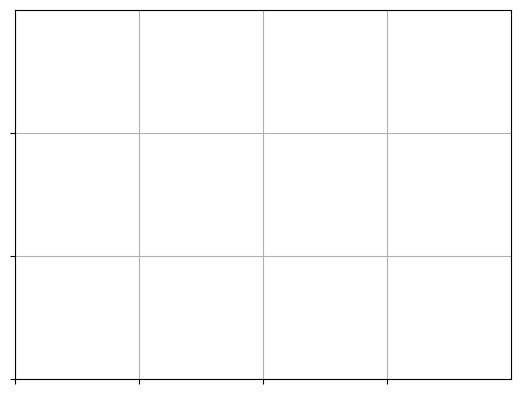

In [ ]:
env.render_v(V)

In [ ]:
import numpy as np

def sarsa(maze, start, end, alpha, gamma, epsilon, episodes):
    Q = np.zeros((*maze.shape, 4))  # 4つの行動（上、下、左、右）を考慮
    actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def choose_action(state):
        if np.random.rand() < epsilon:
            return np.random.choice(4)  # ランダムに行動を選択
        else:
            return np.argmax(Q[state])

    def is_valid_state(state):
        x, y = state
        return 0 <= x < maze.shape[0] and 0 <= y < maze.shape[1]

    for _ in range(episodes):
        state = start
        action = choose_action(state)
        while state != end:
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])

            # 境界外への移動を避ける
            if not is_valid_state(next_state):
                next_state = state

            reward = get_reward(maze, next_state, end)
            next_action = choose_action(next_state)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action

            # 終了状態に到達したらエピソードを終了
            if state == end:
                break

    return Q

def get_reward(maze, state, end):
    if state == end:
        return 1
    else:
        return -0.01

# 例の迷路設定
maze = np.zeros((5, 5))
start = (0, 0)
end = (4, 4)
Q = sarsa(maze, start, end, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000)
Q


array([[[ 0.24888298,  0.24352709,  0.30538735,  0.252233  ],
        [-0.01608383,  0.00697604,  0.36730614,  0.01698193],
        [-0.01116697, -0.01131788, -0.01179254, -0.01101886],
        [-0.00684767, -0.00682956, -0.00601795, -0.00847593],
        [-0.003772  , -0.00406423, -0.00143733, -0.00385948]],

       [[ 0.36222891,  0.28183789,  0.31157091,  0.22429669],
        [ 0.06502223,  0.26313941,  0.46878764,  0.26462066],
        [ 0.18000845,  0.00990676, -0.0071035 , -0.00912517],
        [-0.00371368,  0.00377723,  0.35745931, -0.0043852 ],
        [-0.0019    , -0.00199   ,  0.11750828, -0.002071  ]],

       [[ 0.46595271, -0.00425371,  0.024045  , -0.01044069],
        [ 0.26215423,  0.28601063,  0.55383659,  0.3039507 ],
        [ 0.04316478,  0.0406016 ,  0.51715135, -0.00277527],
        [ 0.52839891, -0.00199   , -0.00199   ,  0.02100683],
        [ 0.05407514,  0.038438  ,  0.80033279,  0.00291052]],

       [[ 0.45638462, -0.00559449,  0.03443959, -0.00555171],
  

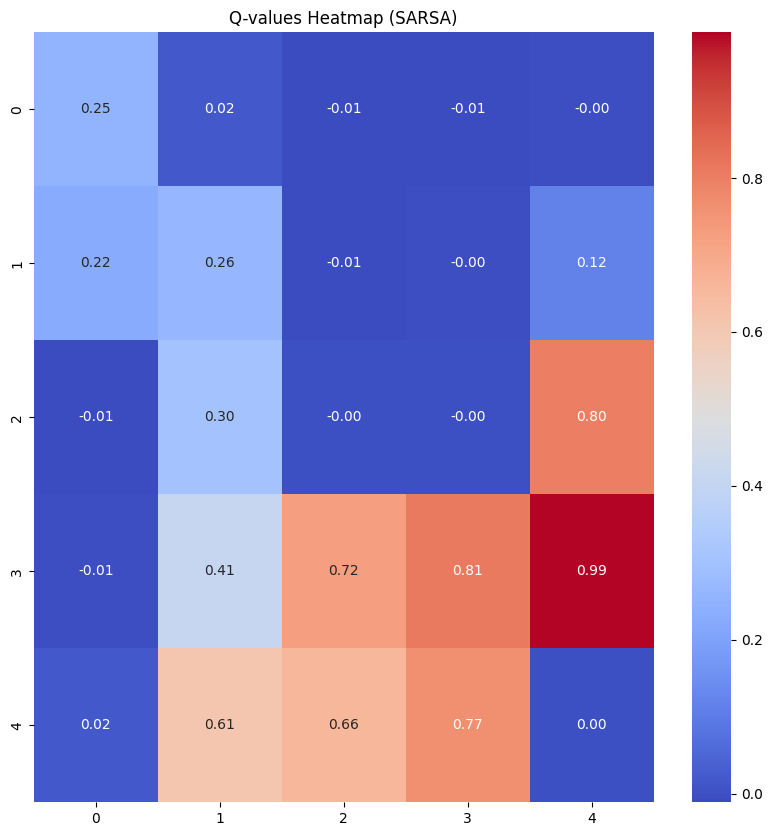

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_q_values_triangular(Q, title="Q-values Heatmap (SARSA)"):
    fig, ax = plt.subplots(figsize=(10, 10))

    # 三角形に分けて表示するための準備
    Q_values = np.full(Q.shape[:2], np.nan)

    # 行動の名前と対応するインデックス
    actions = ['Right', 'Left', 'Down', 'Up']

    for i, action in enumerate(actions):
        for x in range(Q.shape[0]):
            for y in range(Q.shape[1]):
                if i == 0 and x <= y:  # Right: 右上三角形
                    Q_values[x, y] = Q[x, y, i]
                elif i == 1 and x >= y:  # Left: 左上三角形
                    Q_values[x, y] = Q[x, y, i]
                elif i == 2 and x + y >= Q.shape[0] - 1:  # Down: 下三角形
                    Q_values[x, y] = Q[x, y, i]
                elif i == 3 and x + y <= Q.shape[0] - 1:  # Up: 上三角形
                    Q_values[x, y] = Q[x, y, i]

    sns.heatmap(Q_values, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax)
    ax.set_title(title)
    plt.show()

# Q値のヒートマップを三角形に分けて表示
plot_q_values_triangular(Q)


In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models

# 環境の設定（例として）
maze = np.zeros((5, 5))
start = (0, 0)
end = (4, 4)
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

# DQNの構築
def build_model(input_shape, num_actions):
    model = models.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(num_actions, activation='linear'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# 経験リプレイバッファ
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = []
        self.max_size = max_size

    def add(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# 学習の設定
num_actions = len(actions)
input_shape = (25,)
model = build_model(input_shape, num_actions)
target_model = build_model(input_shape, num_actions)
replay_buffer = ReplayBuffer(max_size=2000)

def get_state(maze, state):
    maze_flat = maze.flatten()
    state_index = state[0] * maze.shape[1] + state[1]
    maze_flat[state_index] = 1  # エージェントの位置を1に設定
    return np.reshape(maze_flat, (1, -1))

def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        q_values = model.predict(state)
        return np.argmax(q_values)

def is_valid_state(state):
    x, y = state
    return 0 <= x < maze.shape[0] and 0 <= y < maze.shape[1]

# DQNの学習
def train_dqn(episodes, gamma, epsilon, epsilon_decay, batch_size):
    #global actions # グローバル変数 'actions' にアクセスするためにこの行を追加
    for episode in range(episodes):
        state = start
        total_reward = 0
        while state != end:
            state_input = get_state(maze, state)
            action_index = choose_action(state_input, epsilon)
            action = actions[action_index]
            next_state = (state[0] + action[0], state[1] + action[1])

            # 境界外への移動を避ける
            if not is_valid_state(next_state):
                next_state = state

            reward = 1 if next_state == end else -0.01
            total_reward += reward
            replay_buffer.add((state, action_index, reward, next_state))

            if len(replay_buffer.buffer) >= batch_size:
                minibatch = replay_buffer.sample(batch_size)
                states, actions2, rewards, next_states = zip(*minibatch)

                state_inputs = np.vstack([get_state(maze, s) for s in states])
                next_state_inputs = np.vstack([get_state(maze, s) for s in next_states])

                targets = model.predict(state_inputs)
                next_q_values = target_model.predict(next_state_inputs)

                for i in range(batch_size):
                    targets[i][actions2[i]] = rewards[i] + gamma * np.max(next_q_values[i])

                model.train_on_batch(state_inputs, targets)

            state = next_state

        epsilon = max(epsilon * epsilon_decay, 0.01)
        target_model.set_weights(model.get_weights())
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# DQNの実行
train_dqn(episodes=100, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, batch_size=32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Episode 1/100, Total Reward: 0.6699999999999999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 環境の設定（例としてOpenAI GymのCartPoleを使用）
import gym
env = gym.make('CartPole-v1')

# 状態とアクションの数を設定
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

# Actorネットワークの構築
def build_actor(input_shape, num_actions):
    model = tf.keras.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(num_actions, activation='softmax'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')
    return model

# Criticネットワークの構築
def build_critic(input_shape):
    model = tf.keras.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

actor = build_actor((num_states,), num_actions)
critic = build_critic((num_states,))

# Actor-Criticアルゴリズムの学習
def actor_critic(episodes, gamma):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_input = state.reshape([1, num_states])
            action_probabilities = actor.predict(state_input).flatten()
            action = np.random.choice(num_actions, p=action_probabilities)
            next_state, reward, done, _ = env.step(action)

            next_state_input = next_state.reshape([1, num_states])

            #  'predict'を呼び出す際に'training=True'を設定
            state_value = critic.predict(state_input, training=True)
            next_state_value = critic.predict(next_state_input, training=True)

            target = reward + gamma * next_state_value if not done else reward
            td_error = target - state_value

            # Actorの更新
            with tf.GradientTape() as tape:
                action_probs = actor(state_input, training=True)
                action_log_probs = tf.math.log(action_probs[0, action])
                actor_loss = -action_log_probs * td_error
            actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
            actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

            # Criticの更新
            with tf.GradientTape() as tape:
                critic_loss = tf.keras.losses.MSE(target, state_value)
            critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

            state = next_state
            total_reward += reward

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# 実行
actor_critic(episodes=1000, gamma=0.99)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


TypeError: TensorFlowTrainer.predict() got an unexpected keyword argument 'training'

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models

# 環境の設定（例として）
maze = np.zeros((5, 5))
start = (0, 0)
end = (4, 4)
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

# DQNのモデル構築
def build_model(input_shape, num_actions):
    model = models.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(num_actions, activation='linear'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# 経験リプレイバッファ
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = []
        self.max_size = max_size

    def add(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# 学習の設定
num_actions = len(actions)
input_shape = (25,)
model = build_model(input_shape, num_actions)
target_model = build_model(input_shape, num_actions)
replay_buffer = ReplayBuffer(max_size=2000)

def get_state(maze, state):
    # 迷路の状態をコピーし、エージェントの位置を1として設定
    state_representation = maze.copy()
    state_representation[state] = 1
    return state_representation.flatten().reshape(1, -1)

def choose_action(state, epsilon):
    # ε-グリーディー法による行動選択
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)  # ランダムに行動を選択
    else:
        q_values = model.predict(state)
        return np.argmax(q_values[0])  # Q値が最大の行動を選択

def is_valid_state(state):
    # 次状態が迷路の境界内にあるかどうかをチェック
    x, y = state
    return 0 <= x < maze.shape[0] and 0 <= y < maze.shape[1]

# DQNの学習
def train_dqn(episodes, gamma, epsilon, epsilon_decay, batch_size, target_update_freq):
    for episode in range(episodes):
        state = start
        total_reward = 0
        while state != end:
            state_input = get_state(maze, state)
            action_index = choose_action(state_input, epsilon)
            action = actions[action_index]
            next_state = (state[0] + action[0], state[1] + action[1])

            # 境界外への移動を防ぐためのチェック
            if not is_valid_state(next_state):
                next_state = state

            reward = 1 if next_state == end else -0.01
            total_reward += reward
            replay_buffer.add((state, action_index, reward, next_state))

            if len(replay_buffer.buffer) >= batch_size:
                minibatch = replay_buffer.sample(batch_size)
                states, actions2, rewards, next_states = zip(*minibatch)
                state_inputs = np.vstack([get_state(maze, s) for s in states])
                next_state_inputs = np.vstack([get_state(maze, s) for s in next_states])

                targets = model.predict(state_inputs)
                next_q_values = target_model.predict(next_state_inputs)

                for i in range(batch_size):
                    targets[i][actions2[i]] = rewards[i] + gamma * np.max(next_q_values[i])

                model.train_on_batch(state_inputs, targets)

            state = next_state

        epsilon = max(epsilon * epsilon_decay, 0.01)  # εを減衰させる

        # ターゲットモデルの更新
        if episode % target_update_freq == 0:
            target_model.set_weights(model.get_weights())

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# DQNの実行
train_dqn(episodes=10, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, batch_size=32, target_update_freq=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import gym

# 環境の設定（例としてOpenAI GymのCartPoleを使用）
env = gym.make('CartPole-v1')

# 状態とアクションの数を設定
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

# Actorネットワークの構築
def build_actor(input_shape, num_actions):
    model = tf.keras.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(num_actions, activation='softmax'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')
    return model

# Criticネットワークの構築
def build_critic(input_shape):
    model = tf.keras.Sequential()
    model.add(layers.Dense(24, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Actor-Criticのネットワークを作成
actor = build_actor((num_states,), num_actions)
critic = build_critic((num_states,))

# Actor-Criticアルゴリズムの学習
def actor_critic(episodes, gamma):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_input = state.reshape([1, num_states])
            action_probabilities = actor.predict(state_input).flatten()
            action = np.random.choice(num_actions, p=action_probabilities)
            next_state, reward, done, _ = env.step(action)

            next_state_input = next_state.reshape([1, num_states])
            state_value = critic.predict(state_input)
            next_state_value = critic.predict(next_state_input)
            target = reward + gamma * next_state_value if not done else reward
            td_error = target - state_value

            # Actorの更新
            with tf.GradientTape() as tape:
                action_probs = actor(state_input, training=True)
                action_log_probs = tf.math.log(action_probs[0, action])
                actor_loss = -action_log_probs * td_error
            actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
            actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

            # Criticの更新
            with tf.GradientTape() as tape:
                critic_loss = tf.keras.losses.MSE(target, state_value)
            critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

            state = next_state
            total_reward += reward

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# 実行
actor_critic(episodes=100, gamma=0.99)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/ker

<Sequential name=sequential_21, built=True>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: No gradients provided for any variable.